Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# With Automated Machine Learning
### Energy Demand Forecasting ###

Automated ML empowers data scientists like me to identify an end-to-end machine learning pipeline for any problem, and I am able to achieve higher accuracy while spending far less of my time. 

It enables a much larger number of experiments to be run.

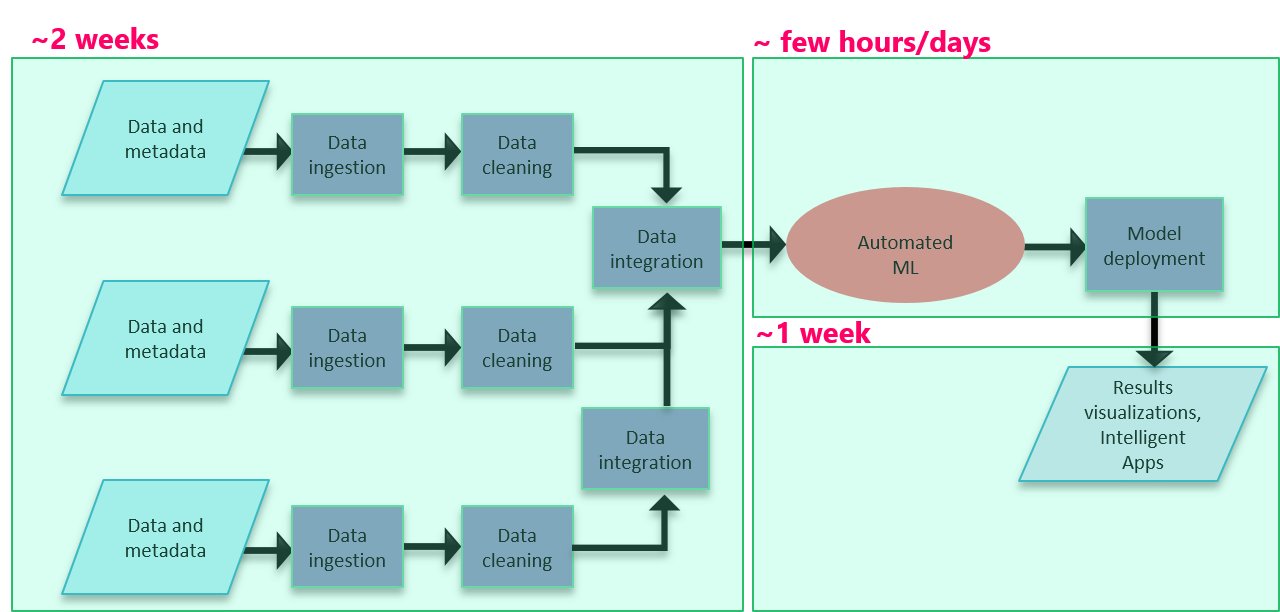

In [1]:
from IPython.display import Image
Image(filename='./WithAutoML.png',width=900)

## Introduction
In this example, we show how AutoML can be used for energy demand forecasting. Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook we will walk through the following steps:
1. Creating an experiment in an existing Workspace


2. Ingesting energy data and enriching it with weather data from Azure Open Datasets

    2.1 - Load the enriched data using Azure Open Datasets
    
    2.2 - Split the data into train and test sets


3. Instantiating AutoMLConfig for Automated ML


4. Training your model using local compute


5. Exploring the results and retrieve the best model
    
    5.1 - View the engineered names for featurized data
    
    5.2 - Test the best fitted model
    
    5.3 - Calculate accuracy metrics
    


## 1. Creating an experiment in an existing workspace 


In [2]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None


from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

As part of the setup you have already created a <b>Workspace</b>. For AutoML you would need to create an <b>Experiment</b>. An <b>Experiment</b> is a named object in a <b>Workspace</b>, which is used to run experiments.

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-energydemandforecasting'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.43
Subscription ID,ea8323fb-dd33-48d1-8ffb-3d771bc5f05c
Workspace,gpu-tech-immersion-aml-70617
Resource Group,ODL-aml-workspace-70617
Location,southeastasia
Project Directory,./sample_projects/automl-local-energydemandforecasting
Run History Name,automl-energydemandforecasting


## 2. Load data 

In [4]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


In [5]:
# let's take note of what columns means what in the data
time_column_name = 'timeStamp'
target_column_name = 'demand'

### 2.2 Split the data into train and test sets


In [6]:
X_train = data[data[time_column_name] < '2017-02-01']
X_test = data[data[time_column_name] >= '2017-02-01']
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

## 3. Instantiating AutoMLConfig for Automated ML

Here we are using new task type "forecasting" for timeseries data training, and other timeseries related settings to instantiate a AutoMLConfig object.

What I love the most of Automated ML is that even if it accelerates my work as data scientist, I still have total <b>Control</b>, <b>Transparency</b>, <b>Visibility</b> on what I am doing with my data, the training piece and all the metrics it is using to evaluate different ML approaches.

Below there is the <b>Configuration file</b> for submitting an Automated Machine Learning experiment in Azure Machine Learning service.

This configuration object contains and persists the parameters for configuring the experiment run parameters, as well as the training data to be used at run time.


|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

In [7]:
automl_settings = {
    "time_column_name": time_column_name    
}


automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings)

## 4. Training your model using local compute
Submitting the configuration will start a new run in this experiment. For local runs, the execution is synchronous.
You will see the currently running iterations printing to the console.

In [ ]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_b8a15d6e-2695-4315-8725-0e6b0f028560
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:39       0.0768  

In [ ]:
local_run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

## 5. Exploring the results and retrieve the best model
Below we select the best pipeline from our iterations. 

The get_output file allows you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [ ]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

### 5.1 View the engineered names for featurized data
Below we display the engineered feature names generated for the featurized data using the time-series featurization.

In [ ]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

### 5.2 Test the Best Fitted Model

For forecasting, we will use the `forecast` function instead of the `predict` function. There are two reasons for this.

We need to pass the recent values of the target variable `y`, whereas the scikit-compatible `predict` function only takes the non-target variables `X`. In our case, the test data immediately follows the training data, and we fill the `y` variable with `NaN`. The `NaN` serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the _forecast origin_ - the last time when the value of the target is known. 

Using the `predict` method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [ ]:
# Replace ALL values in y_pred by NaN. 
# The forecast origin will be at the beginning of the first forecast period
# (which is the same time as the end of the last training period).
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [ ]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

Looking at `X_trans` is also useful to see what featurization happened to the data.

### Calculate accuracy metrics


In [ ]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

In [ ]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

We did not use lags in the previous model specification. Automated ML allows you to use `target_lags` and `target_rolling_window_size`.

Now that we configured target lags, that is the previous values of the target variables, and the prediction is no longer horizon-less. We therefore must specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.